In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
# to the ImageFolder structure
data_dir = "E:/minc-2500/data"

# Number of classes in the dataset
num_classes = 7

model_name = 'resnet'

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


### Using Pre-trained Network as Feature Extractor

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] as feature extractor and train the final layer for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

In [8]:
## basically, we loop through each model in the model_list

model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
acc_history = {}
for model_name in model_list:
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    _, acc_history[model_name] = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/19
----------
train Loss: 1.2751 Acc: 0.6463
val Loss: 1.1070 Acc: 0.7071

Epoch 1/19
----------
train Loss: 1.3106 Acc: 0.6718
val Loss: 1.3265 Acc: 0.6786

Epoch 2/19
----------
train Loss: 1.3440 Acc: 0.6715
val Loss: 1.5868 Acc: 0.7071

Epoch 3/19
----------
train Loss: 1.3096 Acc: 0.6793
val Loss: 1.1274 Acc: 0.7214

Epoch 4/19
----------
train Loss: 1.3504 Acc: 0.6749
val Loss: 1.3650 Acc: 0.6929

Epoch 5/19
----------
train Loss: 1.2661 Acc: 0.6840
val Loss: 1.2047 Acc: 0.6714

Epoch 6/19
----------
train Loss: 1.2800 Acc: 0.6728
val Loss: 1.7537 Acc: 0.7286

Epoch 7/19
----------
train Loss: 1.3074 Acc: 0.6768
val Loss: 1.2522 Acc: 0.7214

Epoch 8/19
----------
train Loss: 1.3159 Acc: 0.6779
val Loss: 1.2459 Acc: 0.7214

Epoch 9/19
----------
train Loss: 1.3033 Acc: 0.6810
val Loss: 1.3436 Acc: 0.7000

Epoch 10/19
----------
train Loss: 1.2840 Acc: 0.6838
val Loss: 1.2254 Acc: 0.7357

Epoch 11/19
----------
train Loss: 1.3185 Acc: 0.6791
val Loss: 1.3093 Acc: 0.6857

Ep

C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Epoch 0/19
----------
train Loss: 0.9975 Acc: 0.6809
val Loss: 0.8781 Acc: 0.7214

Epoch 1/19
----------
train Loss: 0.8973 Acc: 0.7144
val Loss: 0.7928 Acc: 0.7357

Epoch 2/19
----------
train Loss: 0.8687 Acc: 0.7219
val Loss: 0.8348 Acc: 0.7357

Epoch 3/19
----------
train Loss: 0.8434 Acc: 0.7328
val Loss: 0.8456 Acc: 0.7286

Epoch 4/19
----------
train Loss: 0.8421 Acc: 0.7337
val Loss: 0.8172 Acc: 0.7500

Epoch 5/19
----------
train Loss: 0.8234 Acc: 0.7303
val Loss: 0.8376 Acc: 0.7143

Epoch 6/19
----------
train Loss: 0.8272 Acc: 0.7385
val Loss: 0.7901 Acc: 0.7714

Epoch 7/19
----------
train Loss: 0.8284 Acc: 0.7346
val Loss: 0.8025 Acc: 0.7000

Epoch 8/19
----------
train Loss: 0.8236 Acc: 0.7366
val Loss: 0.8441 Acc: 0.7214

Epoch 9/19
----------
train Loss: 0.7999 Acc: 0.7411
val Loss: 0.8002 Acc: 0.7357

Epoch 10/19
----------
train Loss: 0.8184 Acc: 0.7368
val Loss: 0.7445 Acc: 0.7571

Epoch 11/19
----------
train Loss: 0.8187 Acc: 0.7368
val Loss: 0.8113 Acc: 0.7286

Ep

C:\Users\Parth Pankaj Tiwary\Anaconda2\envs\torch\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Epoch 0/19
----------
train Loss: 1.2575 Acc: 0.6590
val Loss: 1.0500 Acc: 0.7357

Epoch 1/19
----------
train Loss: 1.2055 Acc: 0.6942
val Loss: 1.2753 Acc: 0.7071

Epoch 2/19
----------
train Loss: 1.1984 Acc: 0.7026
val Loss: 1.1511 Acc: 0.7286

Epoch 3/19
----------
train Loss: 1.1987 Acc: 0.7029
val Loss: 1.2181 Acc: 0.6643

Epoch 4/19
----------
train Loss: 1.1899 Acc: 0.6994
val Loss: 1.1277 Acc: 0.7571

Epoch 5/19
----------
train Loss: 1.1763 Acc: 0.7086
val Loss: 1.1247 Acc: 0.7286

Epoch 6/19
----------
train Loss: 1.1829 Acc: 0.7048
val Loss: 1.1883 Acc: 0.6857

Epoch 7/19
----------
train Loss: 1.2197 Acc: 0.7006
val Loss: 1.0462 Acc: 0.7429

Epoch 8/19
----------
train Loss: 1.1749 Acc: 0.7127
val Loss: 1.2735 Acc: 0.7000

Epoch 9/19
----------
train Loss: 1.1754 Acc: 0.7078
val Loss: 1.2770 Acc: 0.7429

Epoch 10/19
----------
train Loss: 1.1612 Acc: 0.7091
val Loss: 1.3082 Acc: 0.7286

Epoch 11/19
----------
train Loss: 1.2495 Acc: 0.7000
val Loss: 0.9527 Acc: 0.7500

Ep

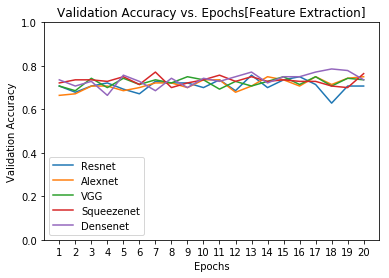

In [9]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
resnet = []
alexnet = []
vgg = []
squeezenet = []
densenet = []

resnet = [h.cpu().numpy() for h in acc_history['resnet']]
alexnet = [h.cpu().numpy() for h in acc_history['alexnet']]
vgg = [h.cpu().numpy() for h in acc_history['vgg']]
squeezenet = [h.cpu().numpy() for h in acc_history['squeezenet']]
densenet = [h.cpu().numpy() for h in acc_history['densenet']]

plt.title("Validation Accuracy vs. Epochs[Feature Extraction]")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),resnet,label="Resnet")
plt.plot(range(1,num_epochs+1),alexnet,label="Alexnet")
plt.plot(range(1,num_epochs+1),vgg,label="VGG")
plt.plot(range(1,num_epochs+1),squeezenet,label="Squeezenet")
plt.plot(range(1,num_epochs+1),densenet,label="Densenet")
# plt.plot(range(1,num_epochs+1),inception,label="Inception")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### Training Pre-trained Network from Scratch

We use ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet'] and train them from scratch for a 7 class classification task. We finally plot the validation accuracies obtained from all the five pre-trained networks over 20 epochs. 

In [10]:
## basically, we loop through each model in the model_list

model_list = ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
acc_history_scratch = {}
for model_name in model_list:
    # Initialize the non-pretrained version of the model used for this run
    model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    _, acc_history_scratch[model_name] = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/19
----------
train Loss: 1.7579 Acc: 0.3361
val Loss: 1.5786 Acc: 0.3929

Epoch 1/19
----------
train Loss: 1.4985 Acc: 0.4429
val Loss: 1.4458 Acc: 0.4357

Epoch 2/19
----------
train Loss: 1.3879 Acc: 0.4944
val Loss: 1.3911 Acc: 0.4714

Epoch 3/19
----------
train Loss: 1.3137 Acc: 0.5211
val Loss: 1.2908 Acc: 0.5500

Epoch 4/19
----------
train Loss: 1.2267 Acc: 0.5596
val Loss: 1.2439 Acc: 0.5500

Epoch 5/19
----------
train Loss: 1.1891 Acc: 0.5687
val Loss: 1.0956 Acc: 0.6071

Epoch 6/19
----------
train Loss: 1.1562 Acc: 0.5831
val Loss: 1.0659 Acc: 0.6000

Epoch 7/19
----------
train Loss: 1.1150 Acc: 0.5979
val Loss: 1.0486 Acc: 0.6071

Epoch 8/19
----------
train Loss: 1.0790 Acc: 0.6201
val Loss: 1.0003 Acc: 0.6429

Epoch 9/19
----------
train Loss: 1.0615 Acc: 0.6215
val Loss: 1.1255 Acc: 0.6071

Epoch 10/19
----------
train Loss: 1.0313 Acc: 0.6350
val Loss: 1.0449 Acc: 0.6000

Epoch 11/19
----------
train Loss: 0.9954 Acc: 0.6454
val Loss: 0.8788 Acc: 0.6500

Ep

RuntimeError: CUDA out of memory. Tried to allocate 122.50 MiB (GPU 0; 3.00 GiB total capacity; 1.75 GiB already allocated; 76.49 MiB free; 123.51 MiB cached)

In [ ]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
resnet = []
alexnet = []
vgg = []
squeezenet = []
densenet = []

resnet = [h.cpu().numpy() for h in acc_history_scratch['resnet']]
alexnet = [h.cpu().numpy() for h in acc_history_scratch['alexnet']]
vgg = [h.cpu().numpy() for h in acc_history_scratch['vgg']]
squeezenet = [h.cpu().numpy() for h in acc_history_scratch['squeezenet']]
densenet = [h.cpu().numpy() for h in acc_history_scratch['densenet']]

plt.title("Validation Accuracy vs. Epochs[Scratch]")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),resnet,label="Resnet")
plt.plot(range(1,num_epochs+1),alexnet,label="Alexnet")
plt.plot(range(1,num_epochs+1),vgg,label="VGG")
plt.plot(range(1,num_epochs+1),squeezenet,label="Squeezenet")
plt.plot(range(1,num_epochs+1),densenet,label="Densenet")
# plt.plot(range(1,num_epochs+1),inception,label="Inception")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()